# Annotation of artefacts

## Introduction

We will show here how artefacts can be identified and then annotated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.  

## Preparation

Import the relevant modules:

In [ ]:
# mount the drive (you'll have to click through the popup to allow it)

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install openneuro-py
!pip install --upgrade mne-bids[full]
!pip install ipympl  # for the widgets in ipynb

clear_output()  # just clear everything because the output is gross and unnecessary

In [ ]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import annotate_muscle_zscore
import matplotlib.pyplot as plt


### File overview
The chapter relies on the input files (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~
and generates the output files:
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif

<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.csv
~~~

Set the path and load the FIF-files:

In [ ]:
bids_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/'  # for other people the path is likely under SharedDrive
deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '01'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
max_suffix = 'sss'
ann_suffix = 'ann'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=max_suffix,
            root=deriv_root, extension='.fif', check=False)

deriv_fname_fif = bids_path.basename.replace(max_suffix, ann_suffix) # fif output filename
deriv_file_1 = op.join(bids_path.directory, deriv_fname_fif)
deriv_fname_csv_1 = deriv_file_1.replace('fif', 'csv') # csv output filename
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')
deriv_file_3 = deriv_file_1.replace('run-01', 'run-03')
deriv_file_4 = deriv_file_1.replace('run-01', 'run-04')
deriv_file_5 = deriv_file_1.replace('run-01', 'run-05')
deriv_files = [deriv_file_1, deriv_file_2,deriv_file_3,deriv_file_4,deriv_file_5]

In [ ]:
raw1 = read_raw_bids(bids_path=bids_path,
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_sss.fif...


<ipython-input-6-916d731a7f6f>:1: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw1 = read_raw_bids(bids_path=bids_path,


    Range : 9000 ... 511999 =      9.000 ...   511.999 secs
Ready.
Reading 0 ... 502999  =      0.000 ...   502.999 secs...


<ipython-input-6-916d731a7f6f>:1: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
<ipython-input-6-916d731a7f6f>:1: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
<ipython-input-6-916d731a7f6f>:1: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw1 = read_raw_bids(bids_path=bids_path,
<ipython-input-6-916d731a7f6f>:1: RuntimeWarning: participants.tsv file not found for drive/MyDri

## Identifying eye blinks

Here we show how the artefacts associated with eye blinks can be marked automatically on the basis of the vertical EOG channel (EOG001 in our case). After bandpass filtering the EOG signal between 1 - 10 Hz, the threshold for blink detection is determined according to:

$$ (max(vEOG) - min(vEOG)) / 4 $$

 Segments being 500 ms long starting 250 ms prior to exceeding the threshold are annotated as blinks.

In [ ]:
eog_events = mne.preprocessing.find_eog_events(raw1, ch_name='EOG001')

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 42 significant peaks
Number of EOG events detected: 42


In total, 543 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object with contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [ ]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw1.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw1.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

## Finding muscle artefacts

Muscle artefacts are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored. If they exceed the value *threshold_muscle*, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.

In [ ]:
threshold_muscle = 10
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.5s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



To check whether the threshold used for the muscle annotation is good for the current data, we plot the z-scores across the recording. The threshold is indicated by a red line.

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

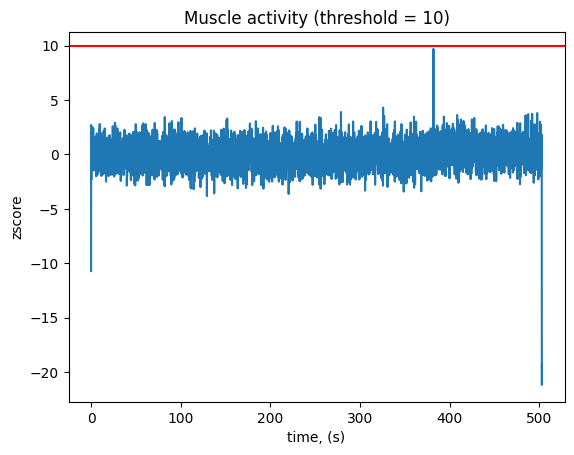

In [ ]:
%matplotlib widget
fig1, ax = plt.subplots()
ax.plot(raw1.times, scores_muscle);
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

From this figure we can see that the threshold is above the baseline level. Still, it captures all the picks in high-gamma activity representing muscle artifacts.

## Include annotations in dataset and inspect

Now mark all the annotations in the data set.


*Calling set_annotations() replaces any annotations currently stored in the Raw object. To prevent that, we first extract their annotations and then combine them together with the blink and muscle annotations*.

In [ ]:
annotations_event = raw1.annotations
raw1.set_annotations(annotations_event + annotations_blink + annotations_muscle)

<ipython-input-11-4cb8a4600657>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw1.set_annotations(annotations_event + annotations_blink + annotations_muscle)


<Raw | sub-CB069_ses-1_task-dur_run-01_sss.fif, 404 x 503000 (503.0 s), ~1.52 GB, data loaded>

To inspect the annotations write:

Using matplotlib as 2D backend.


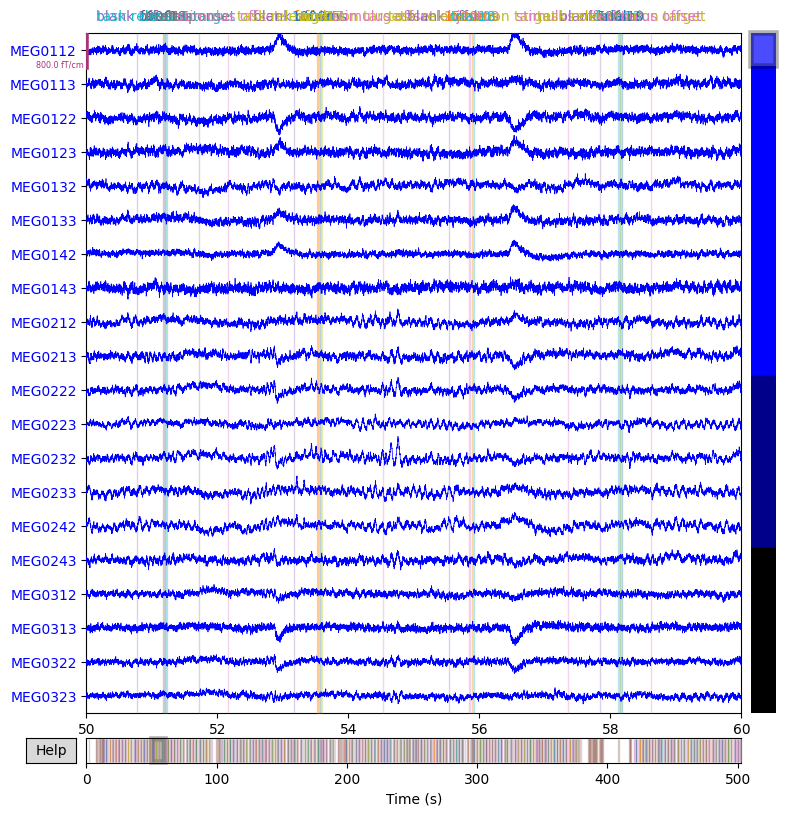

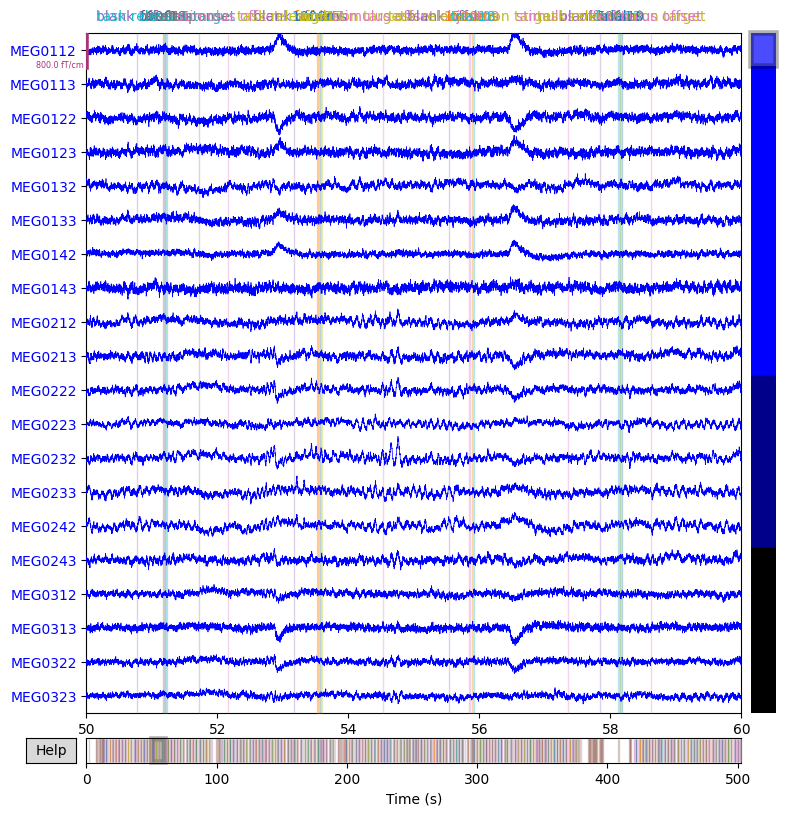

In [ ]:
%matplotlib widget
raw1.plot(start=50)

To specifically inspect the ocular artefacts display the EOG sensors:

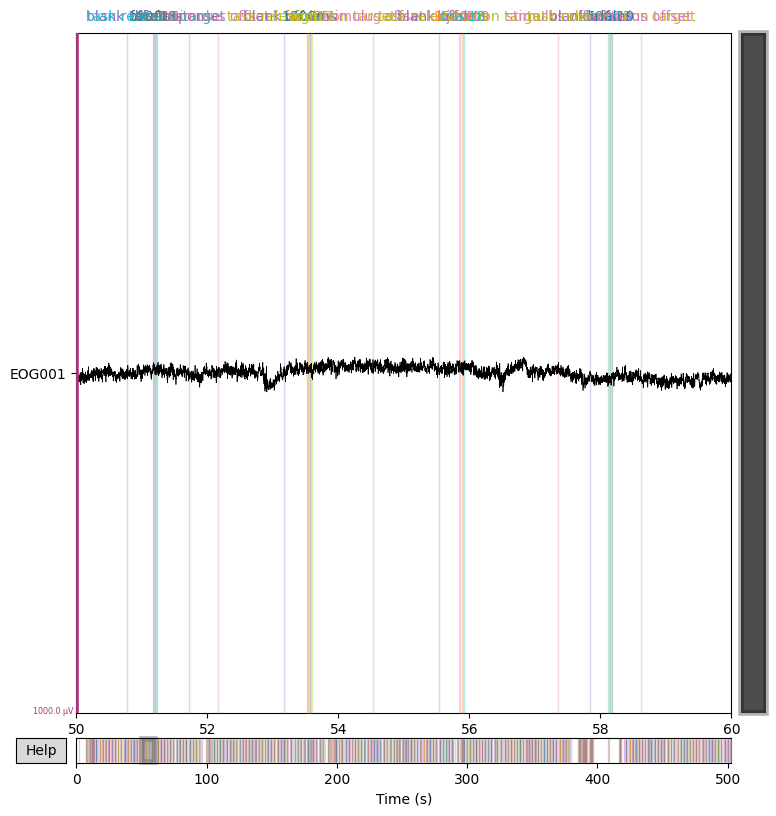

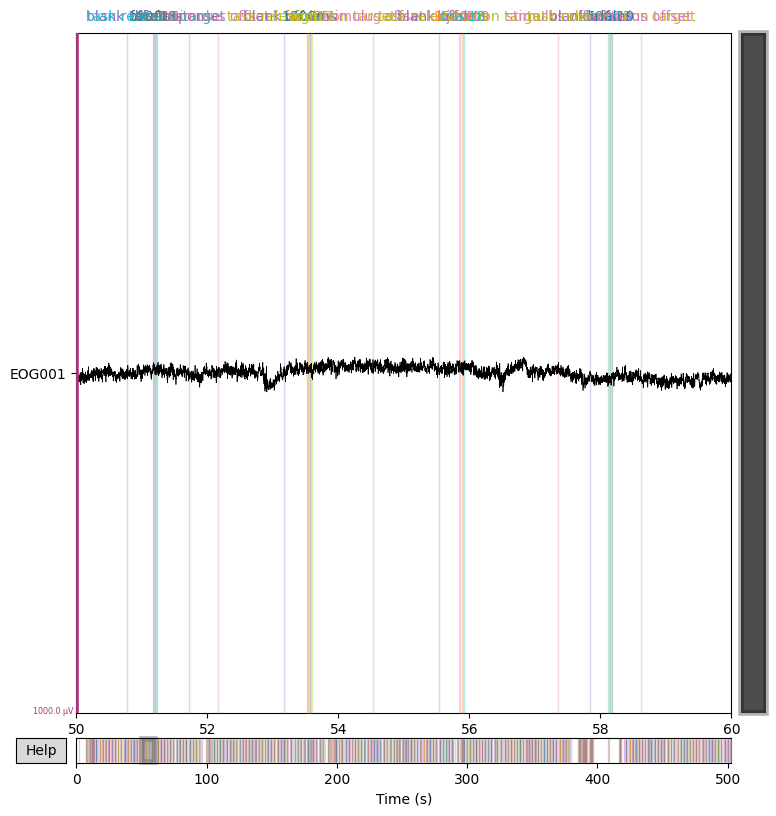

In [ ]:
# Set the channel type as 'eog'
raw1.set_channel_types({'EOG001': 'eog'})

eog_picks = mne.pick_types(raw1.info, meg=False, eog=True)

scl = dict(eog=500e-6)
raw1.plot(order=eog_picks, scalings=scl, start=50)

The sensor layout of the sensors in the MEGIN system will be of use for answering the questions below (adapted from Hu et al., 2018).


![sensorlayout.png](attachment:sensorlayout.png)


**Question 1:** In which sensors are the muscle artefacts particularly strong? Explain why.

**Question 2:** In which sensors are the ocular artefacts particularly strong? Explain why.

**Question 3:** Is the hEOG or vEOG best for identifying saccades? Explain why.


## Save the artefact annotations

Save the annotations in a file to be used in the subsequent sections:

In [ ]:
raw1.save(deriv_file_1, overwrite=True)
raw1.annotations.save(deriv_fname_csv_1, overwrite=True)

Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif


<ipython-input-16-9bce69c4f090>:1: RuntimeWarning: This filename (/content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw1.save(deriv_file_1, overwrite=True)


Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif
[done]


## Perform artefact annotation on the rest of the dataset

Now perform the annotation operations on the second FIF-file:

In [ ]:
for subfile in range(5):
    bids_path=bids_path.update(run=f"{subfile+1:02d}")

    raw2 = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)

    # Blinks
    eog_events = mne.preprocessing.find_eog_events(raw2, ch_name='EOG001')
    n_blinks = len(eog_events)
    onset = eog_events[:, 0] / raw2.info['sfreq'] - 0.25
    onset -= raw2._first_time
    duration = np.repeat(0.5, n_blinks)
    description = ['blink'] * n_blinks
    orig_time = raw2.info['meas_date']
    annotations_blink = mne.Annotations(onset, duration, description, orig_time)

    # Muscle
    threshold_muscle = 10
    annotations_muscle, scores_muscle = annotate_muscle_zscore(
        raw2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
        filter_freq=[110, 140])

    # Annotate the data files
    raw2.set_annotations(raw2.annotations + annotations_blink + annotations_muscle)
    deriv_file_2=deriv_file_1.replace('run-01', f'run-{subfile+1:02d}')
    # Save
    raw2.save(deriv_file_2, overwrite=True)

Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_sss.fif...


<ipython-input-18-8f5523f21182>:4: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2 = read_raw_bids(bids_path=bids_path,


    Range : 9000 ... 511999 =      9.000 ...   511.999 secs
Ready.
Reading 0 ... 502999  =      0.000 ...   502.999 secs...


KeyboardInterrupt: 

## Pregistration and publication

Preregistration: Report the the type of artifacts being annotated as well as the threshold selections.


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were considered 500 ms long centred around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. "

## References

Muthukumaraswamy, S. (2013). High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

